# 일본 대형 온라인 쇼핑몰 Mercari사의 제품에 대해 가격을 예측
- Mercari Price Suggestion Challenge

In [1]:
!pip install konlpy

Defaulting to user installation because normal site-packages is not writeable


In [37]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
!pip install py7zr

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
import py7zr

# 1. 데이터 불러오기

[학습용]

In [19]:
train_df = pd.read_csv('kaggle/train.tsv', sep = '\t')
print(train_df.shape)
train_df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


[test용]

In [20]:
test_df = pd.read_csv('kaggle/test.tsv/test.tsv', sep = '\t')
print(train_df.shape)
test_df.head()

(1482535, 8)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


[데이터 확인]

- name : 제품명
- item_condition_id : 제품상태
- category_name : 카테고리 명
- brand_name : 브랜드 이름
- shipping : 배송비 무료 여부 (1 - 무료, 0 - 유료)
- item_description : 제품에 대한 설명
- price : 제품 가격. 타깃값

# 2. 데이터 확인

[학습용]

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [22]:
train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

-> null 값 확인

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64
10.0      99416
12.0      78986
14.0      76655
16.0      66413
9.0       63643
          ...  
1081.0        1
1213.0        1
1355.0        1
859.0         1
1708.0        1
Name: price, Length: 828, dtype: int64
0    819435
1    663100
Name: shipping, dtype: int64


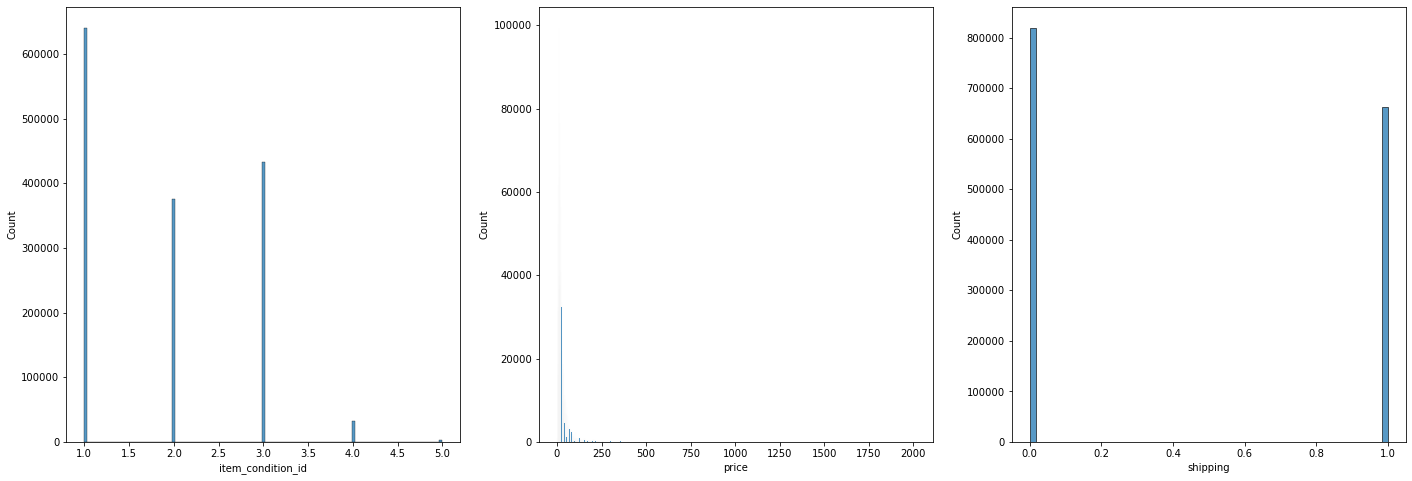

In [31]:
fig, axs = plt.subplots(figsize = (24, 8), nrows = 1, ncols = 3) #1행 3열
feature_ = ['item_condition_id', 'price', 'shipping']

for index_, feature in enumerate(feature_):
    sns.histplot(train_df[feature], ax = axs[index_])
#     plt.title(f'{feature}_')
    print(train_df[feature].value_counts())

-> price 분포도 조절 필요

[test용]

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [33]:
test_df.isnull().sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

1    300081
3    201673
2    175553
4     14853
5      1199
Name: item_condition_id, dtype: int64
0    382929
1    310430
Name: shipping, dtype: int64


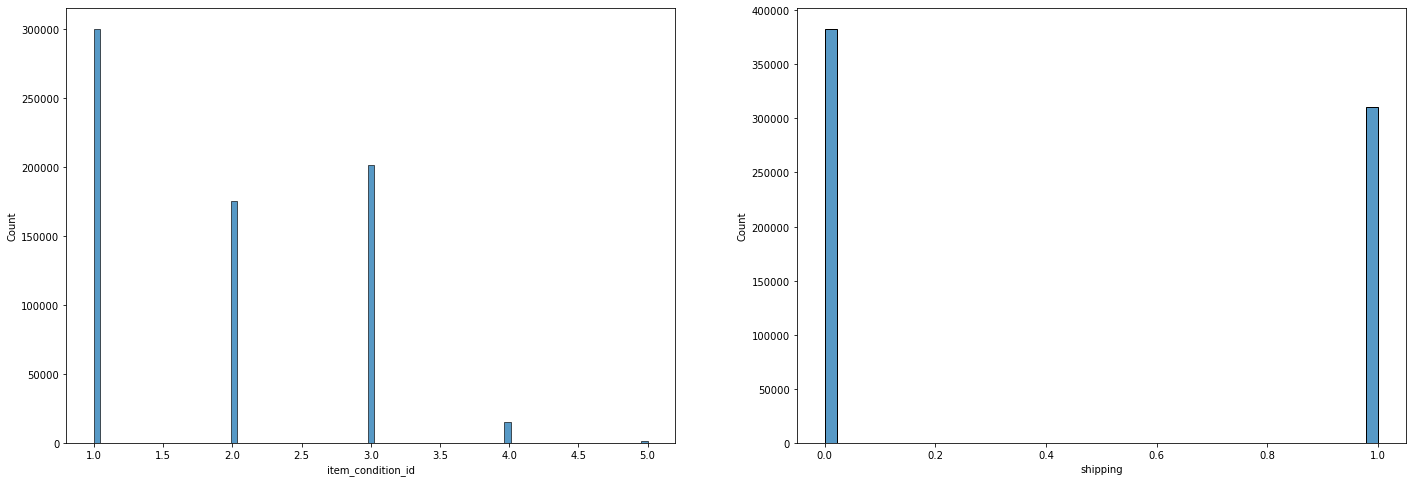

In [34]:
fig, axs = plt.subplots(figsize = (24, 8), nrows = 1, ncols = 2) #1행 2열
feature_ = ['item_condition_id', 'shipping']

for index_, feature in enumerate(feature_):
    sns.histplot(test_df[feature], ax = axs[index_])
#     plt.title(f'{feature}_')
    print(test_df[feature].value_counts())

# 3. 데이터 조작

## 1) price값 로그변환

<AxesSubplot:xlabel='price', ylabel='Count'>

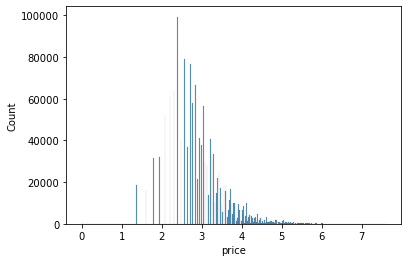

In [38]:
log_train_df = train_df.copy()

log_train_df['price'] = np.log1p(log_train_df['price'])
sns.histplot(log_train_df['price'])

## 2) null값 채우기

In [40]:
log_train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### category_name , brand_name, item_description 확인

In [47]:
log_train_df['brand_name'].value_counts()

PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
The Learning Journey        1
Pampers Baby Fresh          1
Huggies One & Done          1
Classic Media               1
Kids Only                   1
Name: brand_name, Length: 4809, dtype: int64

In [48]:
log_train_df['item_description'].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              82489
New                                                                                               

In [50]:
log_train_df[log_train_df['item_description'].isnull() == True]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
511535,511535,Shoes for Michelle,4,Kids/Girls 0-24 Mos/Shoes,NaN,2.302585,0,NaN
861230,861230,Lipgloss,4,Beauty/Makeup/Lips,NaN,3.912023,0,NaN
1224924,1224924,Disney Minnie Head band,3,Women/Women's Accessories/Hair Accessories,Disney,2.302585,0,NaN
1264242,1264242,For Bianca,3,Women/Women's Accessories/Scarves & Wraps,NaN,2.397895,1,NaN


In [51]:
log_train_df[log_train_df['item_description'] == 'No description yet']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,1.609438,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,3.931826,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,2.079442,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,NaN,1.791759,1,No description yet
...,...,...,...,...,...,...,...,...
1482430,1482430,Nike Jordan's 5c,3,Kids/Girls 2T-5T/Shoes,Nike,2.708050,0,No description yet
1482447,1482447,Wet n Wild Eyelashes,2,Beauty/Makeup/Eyes,Wet n Wild,1.386294,1,No description yet
1482470,1482470,Adidas ultra boost,2,Men/Shoes/Athletic,Adidas,2.302585,0,No description yet
1482496,1482496,Benefit they're real mascara,1,Beauty/Makeup/Eyes,Benefit,2.197225,1,No description yet


In [53]:
log_train_df[log_train_df['brand_name'].isnull() == True]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,4.094345,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,2.197225,0,I realized his pants are on backwards after th...
...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,NaN,2.564949,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,NaN,2.397895,1,Brand new black and white ribbed mock neck bod...
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,2.564949,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,3.828641,1,There is 2 of each one that you see! So 2 red ...


In [56]:
log_train_df[log_train_df['category_name'].isnull() == True]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,4.094345,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,NaN,2.397895,1,For aferg16.
258,258,ACER Laptop,5,NaN,NaN,2.708050,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,2.944439,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,2.302585,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
...,...,...,...,...,...,...,...,...
1481249,1481249,Only For Erin. Do Not Buy,3,NaN,NaN,3.465736,0,No description yet
1481750,1481750,American Eagle Jeggings,2,NaN,American Eagle,2.890372,0,Worn a couple of time Size 4
1482252,1482252,Bundle For All Honey :),3,NaN,NaN,3.713572,0,No description yet
1482443,1482443,HOLD 14g Purple Prong Nipple Bars Rings,1,NaN,NaN,3.135494,1,14g Purple Prong Set Nipple Bars Rings [surgic...


In [46]:
log_train_df['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Dolls and Miniatures/Primitive               1
Handmade/Pets/Tag                                     1
Handmade/Patterns/Accessories                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Pets/Blanket                                 1
Name: category_name, Length: 1287, dtype: int64

### category_name / 기준으로 분류

In [55]:
log_train_df.loc[1, 'category_name'].split('/')

['Electronics', 'Computers & Tablets', 'Components & Parts']

In [60]:
log_train_df.loc[1, 'category_name'].split('/')[0]

'Electronics'

In [59]:
log_train_df.loc[122, 'category_name']

nan

값 채우기

In [67]:
for ind in log_train_df.index:
    try:
        cat_li = log_train_df.loc[ind, 'category_name'].split('/')
    except:
        cat_li = ['Other_Null', 'Other_Null', 'Other_Null']
    log_train_df.loc[ind, 'category_대분류'] = cat_li[0]
    log_train_df.loc[ind, 'category_중분류'] = cat_li[1]
    log_train_df.loc[ind, 'category_소분류'] = cat_li[2]
    
log_train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_대분류,category_중분류,category_소분류
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### 대/중/소분류 값 확인

In [69]:
log_train_df['category_대분류'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: category_대분류, dtype: int64

In [71]:
log_train_df['category_중분류'].nunique()

114

In [72]:
log_train_df['category_소분류'].nunique()

871

#### 나머지 null값 채우기

In [73]:
log_train_df_null = log_train_df.copy()

fill_null_li = ['category_name' , 'brand_name', 'item_description']

for null_ in fill_null_li:
    log_train_df_null[null_] = log_train_df_null[null_].fillna(value = 'Other_Null')
    
log_train_df_null.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
category_대분류         0
category_중분류         0
category_소분류         0
dtype: int64

# 4. 피처 인코딩, 벡터화

## 1) 피처 인코딩

### 피처 값 개수 확인

In [76]:
log_train_df_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   category_대분류       1482535 non-null  object 
 9   category_중분류       1482535 non-null  object 
 10  category_소분류       1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


In [82]:
columns_ = ['name', 'brand_name', 'item_description']

for column in columns_:
    print(f'{column}의 유형')
    print(f'피처 값 형태 : \n {log_train_df_null[column].value_counts()}')
    print()

name의 유형
피처 값 형태 : 
 Bundle                                  2232
Reserved                                 453
Converse                                 445
BUNDLE                                   418
Dress                                    410
                                        ... 
Medium Le Pliage Longchamp bag, pink       1
Victoria secret dream angel heavenly       1
American Eagle kickboot Khakis 8L          1
Jack slippers                              1
Brand new lux de ville wallet              1
Name: name, Length: 1225273, dtype: int64

brand_name의 유형
피처 값 형태 : 
 Other_Null              632682
PINK                     54088
Nike                     54043
Victoria's Secret        48036
LuLaRoe                  31024
                         ...  
The Learning Journey         1
Pampers Baby Fresh           1
Huggies One & Done           1
Classic Media                1
Kids Only                    1
Name: brand_name, Length: 4810, dtype: int64

item_description의 유형
피처 값 형

[인코딩, 벡터화 방법]

name : 짧은 단어 위주_count 벡터화 <br>
brand_name, category_대/중/소, shipping(카테고리형태_0, 1), item_condition(카테고리형태_1, 2, 3, 4, 5): 원_핫인코딩 <br>
item_description : 문자열이 길어 TF-IDF 변환

### name 컬럼 Count 벡터화

In [115]:
from sklearn.feature_extraction.text import CountVectorizer

# 객체 생성
cnt_vec = CountVectorizer()

# 최종 output 형태
X_name = cnt_vec.fit_transform(log_train_df_null.name)

X_name.shape

(1482535, 105757)

### item_description 컬럼 TF-IDF 벡터화

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 객체 생성
tfid_desc = TfidfVectorizer(max_features = 50000, ngram_range = (1, 3), stop_words = 'english')

# 최종 output 형태
X_desc = tfid_desc.fit_transform(log_train_df_null['item_description'])

X_desc.shape

(1482535, 50000)

※ name, item_description 벡터화 출력 값은 희소행렬 형태 <br>
-> 나머지 원핫 인코딩 후 형태도 희소행렬 형태로 변환 필요

*LabelBinarizer 클래스 : 사이킷런에서 제공하는 원 - 핫 인코딩 클래스로 희소 행렬 형태로 출력해줌 <br>
이때, 파라미터 값을 sparse_out = True로 설정 

### 나머지 컬럼 희소행렬 형태의 One_Hot 인코딩 변환

In [89]:
from sklearn.preprocessing import LabelBinarizer

# 함수 생성
def change_one_hot(column):
    lb_ = LabelBinarizer(sparse_output=True)
    X_column = lb_.fit_transform(log_train_df_null[column])
    
    return X_column

# 함수 대입
X_brand = change_one_hot('brand_name')
X_cate_대분류 = change_one_hot('category_대분류')
X_cate_중분류 = change_one_hot('category_중분류')
X_cate_소분류 = change_one_hot('category_소분류')
X_shipping = change_one_hot('shipping')
X_con = change_one_hot('item_condition_id')    

#### 변환 값 확인

In [91]:
print(type(X_brand), type(X_con), type(X_shipping))

for i in [X_brand, X_cate_대분류, X_cate_중분류, X_cate_소분류, X_shipping, X_con]:
    print(f'{i.shape}')

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
(1482535, 4810)
(1482535, 11)
(1482535, 114)
(1482535, 871)
(1482535, 1)
(1482535, 5)


#### 데이터 결합
- hstack()을 이용해 결합_메모리 차지를 많이해서 생략
- 총 데이터 크기(1482535, 161569)

In [ ]:
# hstack 사용 코드
hstack([인코딩, 벡터화한 컬럼 리스트]).tocsr()
# 지울때
del hstack([인코딩, 벡터화한 컬럼 리스트]).tocsr()
gc.collect()

# 5. 릿지 회귀 모델 구축 및 평가

평가 방법 : RMSLE

In [109]:
# RMSLE 방식 사용

def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2))) # 오류값에 로그를 취해 RMSE를 구하는 방식 


def evaluate_org_price(y_test, preds):
    
    # (1) 로그변환 전 다시 원복
    preds_exmpm = np.expm1(preds) 
    y_test_exmpm = np.expm1(y_test)
    
    rmslt_result = rmsle(y_test_exmpm, preds_exmpm) # 여기서 로그변환을 위해 (1)을 수행
    return rmslt_result

모델 학습/예측

In [110]:
# 훈련용, 테스트용 나누기

# 여기서 hstack 사용해 test용 train용 추출
from scipy.sparse import hstack
import gc

from sklearn.model_selection import train_test_split, cross_val_score

def model_train_predict(model, matrix_list):
    #희소행렬 형태의 컬럼 결합
    
    X = hstack(matrix_list).tocsr() # 한번에 여러컬럼을 밀집행렬로 변환
    
    X_train, X_test, y_train, y_test = train_test_split(X, log_train_df_null['price'], test_size = 0.2, random_state = 156)
    
    # 모델 학습 및 예측
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

## [적용]

릿지 사용

In [111]:
log_train_df_null.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'category_대분류', 'category_중분류',
       'category_소분류'],
      dtype='object')

In [118]:
from sklearn.linear_model import Ridge, LogisticRegression

linear_model = Ridge(solver = 'lsqr', fit_intercept = False) #lsqr : 전용 정규화된 최소 제곱 루틴 scipy.sparse.linalg.lsqr을 사용, 가장 빠르며 반복적 인 절차를 사용

# 1. 상품 설명 제외하고 넣어보기 (텍스트 형태의 속성이 얼마나 영향을 미치는지 확인)
sparse_matrix_list = (X_brand, X_con, X_shipping, X_cate_대분류, X_cate_중분류, X_cate_소분류)
# X_brand, X_con, X_shipping, X_cate_대분류, X_cate_중분류, X_cate_소분류

# 함수 적용(모델 분류)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)

print('Item Description 을 제외했을 때 rmsle값')
# rmsle 함수 적용
print(evaluate_org_price(y_test, linear_preds), '\n')

# 2. 상품 설명 포함하고 넣어보기
sparse_matrix_list = (X_brand, X_desc, X_con, X_shipping, X_cate_대분류, X_cate_중분류, X_cate_소분류)

linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)

print('Item Description 을 포함했을 때 rmsle값')
# rmsle 함수 적용
print(evaluate_org_price(y_test, linear_preds))

Item Description 을 제외했을 때 rmsle값
0.5825744319395965 

Item Description 을 포함했을 때 rmsle값
0.5168790239876937


[최종 예측 평가]

In [117]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_brand, X_desc, X_con, X_shipping, X_cate_대분류, X_cate_중분류, X_cate_소분류)

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LGBM rmsle 값')
print(evaluate_org_price(y_test, lgbm_preds))

LGBM rmsle 값
0.49510782342649334


# 6. 최종 예측값 도출

In [121]:
# LightGBM 과 Ridge 예측값 결합
# LightGBM 결괏값 * 0.45 + Ridge 결괏값 * 0.55 (배율 산정 _ 임의_전부 확인해보기)

gbm_ = [0.3, 0.35, 0.45, 0.5, 0.55, 0.6]
righ_ = [0.7, 0.65, 0.55, 0.5, 0.45, 0.4]

for gbm, rig in zip(gbm_, righ_):
    preds = lgbm_preds * gbm + linear_preds * rig
    print(f'############### gbm * {gbm} + ridge * {rig} 일때 RMSLE값 ###############')
    print(evaluate_org_price(y_test, preds))
    print()

############### gbm * 0.3 + ridge * 0.7 일때 RMSLE값 ###############
0.49940304325522195

############### gbm * 0.35 + ridge * 0.65 일때 RMSLE값 ###############
0.49736561157587517

############### gbm * 0.45 + ridge * 0.55 일때 RMSLE값 ###############
0.4940722078787095

############### gbm * 0.5 + ridge * 0.5 일때 RMSLE값 ###############
0.4928214581898318

############### gbm * 0.55 + ridge * 0.45 일때 RMSLE값 ###############
0.4918375033851103

############### gbm * 0.6 + ridge * 0.4 일때 RMSLE값 ###############
0.49112194702472073



gbm * 0.6 + ridge * 0.4 일 때, RMSLE값이 가장 좋게 나옴